#### Kaggle competition

Label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond


#### What the data looks like ? 
Train-jpg: 40K+ satelite photos <br>
train_v2: (image_name, tags) Unique tags 449 <br>
So this is a multilabel image classification problem

#### Challenge
Unlike dog and cat image recognition, the image set are very similar in colors
```terminal
source activate tensorflow_p36
```

In [1]:
#!nvidia-smi CUDA monitoring

In [2]:
from __future__ import division
from scipy.integrate import cumtrapz
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math, glob, os
import cv2

In [3]:
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
# kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
labels = pd.read_csv(kaggle_path+'train_v2.csv')
print ('Number of unique tags',len(labels['tags'].unique()))
labels.head(5)

Number of unique tags 449


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# def validation():
#     df = pd.read_csv(kaggle_path+'test_v2_file_mapping.csv')
#     return df.head(3)
# validation()

In [5]:
def example_photos(rows,columns):
    fig=plt.figure(figsize=(15, 15))
    for i in range(1, columns*rows +1):
        path = kaggle_path+f'train-jpg/train_{i}.jpg'
        img = cv2.imread(path)
        ax = fig.add_subplot(rows, columns, i)
        ax.set_xlabel(labels.tags[i])
        plt.imshow(img)
# example_photos(rows=4,columns=5)

#### Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 

###  Tags EDA
- Most tags contains primary
- Clear has strong negative correlations with cloudy, haze, partly 

In [6]:
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
import keras.backend as K

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
texts = labels.tags.tolist()
tokenizer = Tokenizer(filters = '"#()*+,-./:;<=>?@[\]^`{|}~')
tokenizer.fit_on_texts(texts)

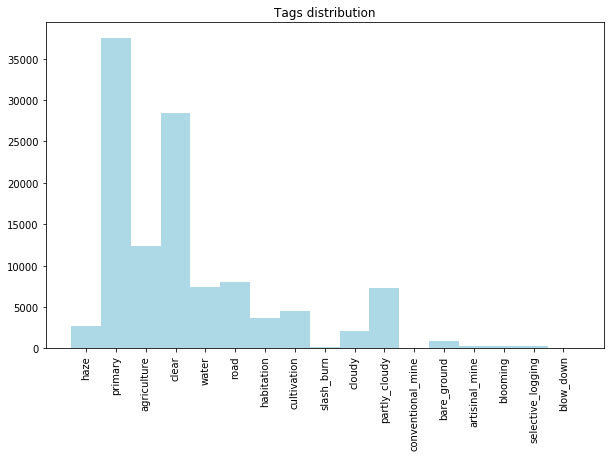

In [24]:
def plot_tags():
    tags = tokenizer.word_docs
    fig  = plt.figure(figsize=(10, 6))
    plt.bar(tags.keys(), tags.values(), 1, color='lightblue')
    plt.xticks(rotation=90)
    plt.title('Tags distribution')

def img_multilabel(plot=True):
    M  = tokenizer.texts_to_matrix(texts, mode='count')
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[1:-1]
    df = df[cols]
    if plot:
        corr = df.corr()
        fig=plt.figure(figsize=(10, 8))
        sns.heatmap(corr)
    return df

plot_tags()
# df_label = img_multilabel(False)

In [27]:
tags = tokenizer.word_docs

list(zip(tags.keys(), tags.values()))

[('haze', 2697),
 ('primary', 37513),
 ('agriculture', 12315),
 ('clear', 28431),
 ('water', 7411),
 ('road', 8071),
 ('habitation', 3660),
 ('cultivation', 4477),
 ('slash_burn', 209),
 ('cloudy', 2089),
 ('partly_cloudy', 7261),
 ('conventional_mine', 100),
 ('bare_ground', 862),
 ('artisinal_mine', 339),
 ('blooming', 332),
 ('selective_logging', 340),
 ('blow_down', 98)]

In [9]:
haze_id = df_label.loc[df_label['haze']==1].index.values
clear_id = df_label.loc[df_label['clear']==1].index.values
print ('haze vs clear ',len(haze_id),' : ',len(clear_id))

haze vs clear  2697  :  28431


### Preprocess Image
#### 1. Calculate haze degree
Source: [Detecting Foggy Images and Estimating the Haze Degree Factor](https://www.omicsonline.org/open-access/detecting-foggy-images-and-estimating-the-haze-degree-factor-jcsb.1000226.pdf)

Define haze degree as w, where w is a number between (0,1). Smaller w indicates a clearer image while haze images have greater w.  For example, w greater than 0.7 means 80%-100% of the image area is hazed.

#### 2. Dehaze images
Source: [Single Image Haze Removal Using Dark Channel Prior](https://www.robots.ox.ac.uk/~vgg/rg/papers/hazeremoval.pdf)

The following formula is widely used to describe the formation of a haze image

$I(x) = J(x)t(x) + A(1-t(x))$

where *I* is the observed intensity, *J* represents the original haze-free image to be recovered, *A* is the global atmospheric light, and *t* is an exponential decay distribution .

The aim is to recover *J* from *I*. We can achieve that by tuning *t*, as *t* has a formula of

$t(x) = 1- w\times min[min(\frac{I_{c}(y)}{A^{c}})]$
,where *w* is weight coefficient, *c* is the dark channel color (darkest channel of RGB channel)

In [71]:
"""Single image dehazing."""
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    """return Atomospheric light A """
    # pick top 0.1% brightest pixels in the dark channel ~ most hazeopaque
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num 
    dark_channel = find_dark_channel(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:  # create 65 different channels 
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break
    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t
    return max_channel.intensity

def find_dark_channel(img): #get darkest RBG channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze_function(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])
    outimg = np.zeros(img.shape, img.dtype)
    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def dehaze_image(path,w = 0.95, t0 = 0.55):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
    outimg = dehaze_function(img, light_intensity, 20, t0, w)
    return outimg

def example_photo_no(image_id,train=True):
    if train:
        path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    else:
        path = kaggle_path+f'test-jpg/test_{image_id}.jpg'
    img = cv2.imread(path)
    plt.imshow(img)
    
def intensity_plot(path):
    img = cv2.imread(path)
    color = ('b','g','r')
    histr = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(histr)
## %%%%%%%%      GRB PLOT   %%%%%%%%
#     for i,col in enumerate(color):
#         histr = cv2.calcHist([img],[i],None,[256],[0,256])
#         plt.plot(histr,color = col)
#         plt.xlim([0,256])
# ##  %%%%%%%     CDF plot    %%%%%%%%
#     values, bins = np.histogram(img.ravel(),256,[0,256],normed=True)
#     cum = np.cumsum(values)
#     plt.plot(bins[:-1],cum)



In [11]:
miu, v, sigma = 5.1,2.9,.2461
def calculate_haziness(image_id):
    path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    A = find_intensity_of_atmospheric_light(img, gray)
    D = img.min(2).sum()/(img.shape[0]*img.shape[1])
    B = img.max(2).sum()/(img.shape[0]*img.shape[1])
    C = B - D
    w = math.e**(-0.5*(miu*(A-D)/A+v*C/A))
    return (image_id,w)

def compare_photos(image_id):
    path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    fig=plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(211)
    dehazed_img = dehaze_image(path)
    plt.imshow(dehazed_img)
    fig.add_subplot(212,sharex=ax1)
    example_photo_no(image_id)
    plt.show()

In [12]:
# from multiprocessing.dummy import Pool as ThreadPool 
# pool = ThreadPool(10) 
# N = 1000
# w = map(calculate_haziness,range(N))
# pool.close()
# pool.join()
# df_w = pd.DataFrame(data = w, columns = ['image_id','w'])

In [13]:
calculate_haziness(5)

(5, 0.4792106739524277)

top picture is haze-free image, bottom one is the original picture


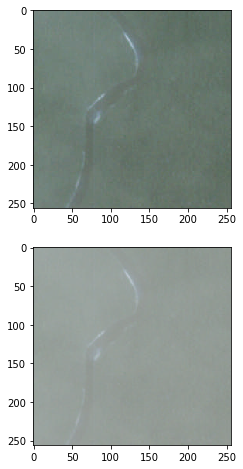

In [14]:
print ('top picture is haze-free image, bottom one is the original picture')
compare_photos(5)

### Logistic Regression 
- Distiguish haze | clear label

### 1 Neural Network vanilla model
- Importing the Keras libraries and packages
- Sequential:<br> initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

#### 1.1 Load Data

#### 1.2 Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric

In [15]:
def load_train_test(train_ids,test_ids):
    read = lambda i: cv2.imread(kaggle_path+f'train-jpg/train_{i}.jpg')
    train_array = np.array(list(map(read,train_ids)))
    test_array = np.array(list(map(read,test_ids)))
    return train_array,test_array

def load_data():
    y_train, y_test = train_test_split(df_label, test_size=0.3,random_state=50)
    X_train, X_test = load_train_test(y_train.index.tolist(),y_test.index.tolist())
    return X_train,y_train,X_test,y_test


In [16]:
X_train,y_train,X_test,y_test = load_data()
print (X_test.shape,y_test.shape)

(12144, 256, 256, 3) (12144, 17)


In [18]:
from tensorflow.contrib import metrics
# def F2_score(y_true, y_pred):
#     prec, _ = metrics.streaming_precision(y_true, y_pred)
#     rec, _ = metrics.streaming_recall(y_true, y_pred)
#     return (1+4)*prec*rec/(4*prec+rec)

In [28]:
def build_layers2():
    model = Sequential()
    model.add(Conv2D(32, (16, 16), input_shape = (256, 256, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (12, 12)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17))
    model.add(Activation('softmax'))
    return model

In [98]:
def F2_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return (1+4)*precision*recall/(4*precision+recall)

def build_layers():
    """32 filters of size 12x12
        input image size 256 x 256, 3 for RGB
    """
    no_features = 17
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(12,12), activation = 'relu',input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = no_features, activation = 'sigmoid'))
    return model


def get_model():
#     model = build_layers()
    model = build_layers2()

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                  metrics = ['accuracy',F2_score])
    return model

def train_model():
    model = get_model()
    model.fit(X_train, y_train, epochs=1, batch_size=200)
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss: %.3f  accuracy: %.3f F2 score: %.3f.' %(score[0],score[1],score[2]))
    return model
    

In [64]:
model = train_model()
y_pred = model.predict(X_test)

Epoch 1/1
28335/28335 [==============================] - 91s 3ms/step - loss: 2.5613 - acc: 0.8400 - F2_score: 0.4117
Test loss: 2.504  accuracy: 0.844 F2 score: 0.412.


In [99]:
model2 = train_model()
y_pred2 = model2.predict(X_test)

Epoch 1/1
28335/28335 [==============================] - 143s 5ms/step - loss: 3.4370 - acc: 0.7854 - F2_score: 0.0446
Test loss: 3.479  accuracy: 0.784 F2 score: nan.


#### 1.3 Implementation
Build different models and test

In [93]:
def test_abs_accuracy(y_pred,y_test):
    L = []
    for i in range(12144):
        if np.array_equal(y_pred[i],y_test.values[i]):
            L.append(i)
    print ('no of images detected: %d, with acc of %.3f' % (len(L),len(L)/12144))
    return L


In [94]:
L = test_abs_accuracy(y_pred,y_test)

no of images detected: 1118, with acc of 0.092


In [100]:
L2 = test_abs_accuracy(y_pred2,y_test)

no of images detected: 0, with acc of 0.000


In [90]:
y_test[83:88]

,conventional_mine,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down
39726,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34857,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19070,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37108,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38873,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
y_pred[11:12]

array([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)